## Libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

## The Dataset

In [27]:
bundesliga = pd.read_csv("bundesliga.csv")

## Optional Objective

In [31]:
bundesliga_matches = bundesliga[['SEASON', 'HOMETEAM', 'AWAYTEAM', 'FTHG', 'FTAG']]

team_stat = {}

for _, row in bundesliga_matches.iterrows():
    season = row['SEASON']
    home_team, away_team = row['HOMETEAM'], row['AWAYTEAM']
    home_goals, away_goals = row['FTHG'], row['FTAG']
    
    for team in [home_team, away_team]:
        if (season, team) not in team_stat:
            team_stat[(season, team)] = {'M': 0, 'W': 0, 'D': 0, 'L': 0, 'GF': 0, 'GA': 0, 'POINTS': 0}

    team_stat[(season, home_team)]['M'] += 1
    team_stat[(season, away_team)]['M'] += 1
    team_stat[(season, home_team)]['GF'] += home_goals
    team_stat[(season, home_team)]['GA'] += away_goals
    team_stat[(season, away_team)]['GF'] += away_goals
    team_stat[(season, away_team)]['GA'] += home_goals
    
    if home_goals > away_goals:  # if home wins 
        team_stat[(season, home_team)]['W'] += 1
        team_stat[(season, away_team)]['L'] += 1
        team_stat[(season, home_team)]['POINTS'] += 3
    elif home_goals < away_goals:  # if away wisn
        team_stat[(season, away_team)]['W'] += 1
        team_stat[(season, home_team)]['L'] += 1
        team_stat[(season, away_team)]['POINTS'] += 3
    else:  # when it's a draw
        team_stat[(season, home_team)]['D'] += 1
        team_stat[(season, away_team)]['D'] += 1
        team_stat[(season, home_team)]['POINTS'] += 1
        team_stat[(season, away_team)]['POINTS'] += 1

final_bundesliga = pd.DataFrame([
    {'SEASON': season, 'TEAM': team, **stats} for (season, team), stats in team_stat.items()
])

final_bundesliga['DIFF'] = df_final['GF'] - df_final['GA']

final_bundesliga.sort_values(by=['SEASON', 'POINTS', 'DIFF', 'GF'], ascending=[True, False, False, False], inplace=True)

final_bundesliga['POSITION'] = final_bundesliga.groupby('SEASON').cumcount() + 1

final_bundesliga = final_bundesliga[['TEAM', 'M', 'W', 'D', 'L', 'GF', 'GA', 'DIFF', 'POINTS', 'POSITION', 'SEASON']]

final_bundesliga.to_csv("bundesliga_final_standings.csv", index=False)

final_bundesliga.head()

,TEAM,M,W,D,L,GF,GA,DIFF,POINTS,POSITION,SEASON
0,Bayern Munich,34,17,10,7,68,37,31,61,1,1994
7,Kaiserslautern,34,18,7,9,64,36,28,61,2,1994
2,Dortmund,34,15,9,10,49,45,4,54,3,1994
13,Ein Frankfurt,34,15,8,11,57,41,16,53,4,1994
5,Leverkusen,34,14,11,9,60,47,13,53,5,1994


## Part 1. Trend Analysis

### 1. Analyse trend of goals per season. 

In [35]:
bundesliga["TotalGoals"] = bundesliga["FTHG"] + bundesliga["FTAG"]

season_goals = bundesliga.groupby("SEASON").agg(
    TotalGoalsPM = ("TotalGoals", "sum"),
    AvgGoalsPM = ("TotalGoals", "mean")
)

print(season_goals)

        TotalGoalsPM  AvgGoalsPM
SEASON                          
1994             895    2.924837
1995             918    3.000000
1996             831    2.715686
1997             911    2.977124
1998             883    2.885621
1999             866    2.830065
2000             885    2.892157
2001             897    2.931373
2002             893    2.918301
2003             821    2.683007
2004             909    2.970588
2005             890    2.908497
2006             861    2.813725
2007             837    2.735294
2008             860    2.810458
2009             894    2.921569
2010             866    2.830065
2011             894    2.921569
2012             875    2.859477
2013             898    2.934641
2014             967    3.160131
2015             843    2.754902
2016             866    2.830065
2017             877    2.866013
2018             855    2.794118
2019             973    3.179739


**PM** stands for *"per match"*

### 2. Goal Distribution Per Season.

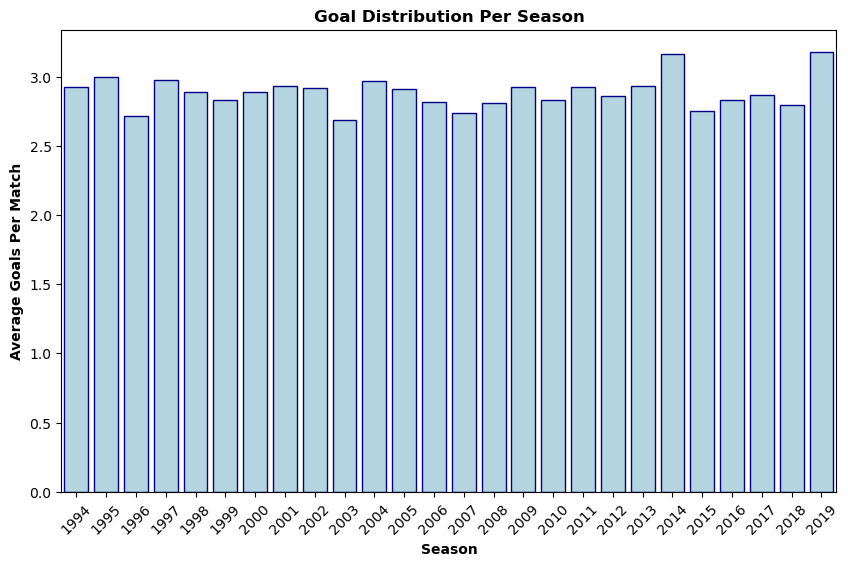

In [39]:
plt.figure(figsize = (10, 6))
sns.barplot(data=season_goals, x = "SEASON", y = "AvgGoalsPM", edgecolor = "darkblue", color = "lightblue")
plt.title("Goal Distribution Per Season", fontweight = "bold")
plt.xlabel("Season", fontweight = "bold")
plt.ylabel("Average Goals Per Match", fontweight = "bold")
plt.xticks(rotation = 45)
plt.show()

### 3. Create line charts for each season.

In [42]:
home_goals = bundesliga.groupby(['SEASON', 'HOMETEAM'])['FTHG'].sum()
away_goals = bundesliga.groupby(['SEASON', 'AWAYTEAM'])['FTAG'].sum()

home_goals = home_goals.rename('TOTAL_GOALS')
away_goals = away_goals.rename('TOTAL_GOALS')

home_goals = home_goals.reset_index()
away_goals = away_goals.reset_index()

home_goals['TEAM'] = home_goals['HOMETEAM']
away_goals['TEAM'] = away_goals['AWAYTEAM']
team_goals = pd.concat([home_goals[['SEASON', 'TEAM', 'TOTAL_GOALS']], away_goals[['SEASON', 'TEAM', 'TOTAL_GOALS']]])

with PdfPages('season_goals.pdf') as pdf:
    for season in team_goals['SEASON'].unique():
        season_data = team_goals[team_goals['SEASON'] == season]
        
        plt.figure(figsize=(9, 6))
        
        bayern_data = season_data[season_data['TEAM'] == 'Bayern Munich']
        plt.plot(bayern_data['TEAM'], bayern_data['TOTAL_GOALS'], color='red', marker='o', label=f'Bayern Munich ({bayern_data["TOTAL_GOALS"].sum()})')

        for team in season_data['TEAM'].unique():
            if team != 'Bayern Munich':
                team_data = season_data[season_data['TEAM'] == team]
                plt.plot(team_data['TEAM'], team_data['TOTAL_GOALS'], color='gray', marker='o')

        total_goals_bayern = bayern_data['TOTAL_GOALS'].sum()
        plt.title(f'Season {season} - Total Goals: {season_data["TOTAL_GOALS"].sum()}')
        plt.figtext(0.5, 0.01, f'Total goals scored by Bayern Munchen: {total_goals_bayern}', wrap=True, horizontalalignment='center', fontsize=10)
        
        plt.xlabel('Team')
        plt.ylabel('Goals Scored')
        plt.xticks(rotation=90)  
        
        plt.legend() 
        plt.xticks(rotation=70, fontsize=4.75)
        plt.grid(True)
        
        pdf.savefig()
        plt.close()

print("Graphs saved in 'season_goals.pdf'")

Graphs saved in 'season_goals.pdf'


## Part 3

### 1. Team Trajectories and Volatility

In [46]:
def calculate_points(row):
    if row['FTHG'] > row['FTAG']: #if home wins then we assign 3 to home and 0 to away.
        return 3, 0  
    elif row['FTHG'] < row['FTAG']: #if home wins then we assign 3 to home and 0 to away.
        return 0, 3  
    else:
        return 1, 1  # in other case (draw) we assign 1 to home and 1 to away. (same logic as in csv conversion above)


bundesliga[['HOME_POINTS', 'AWAY_POINTS']] = bundesliga.apply(calculate_points, axis=1, result_type='expand')

home_points = bundesliga.groupby(['SEASON', 'HOMETEAM'])['HOME_POINTS'].sum().reset_index()
away_points = bundesliga.groupby(['SEASON', 'AWAYTEAM'])['AWAY_POINTS'].sum().reset_index()

home_points.rename(columns={'HOMETEAM': 'TEAM', 'HOME_POINTS': 'POINTS'}, inplace=True)
away_points.rename(columns={'AWAYTEAM': 'TEAM', 'AWAY_POINTS': 'POINTS'}, inplace=True)

team_points = pd.concat([home_points, away_points])

team_points['RANK'] = team_points.groupby('SEASON')['POINTS'].rank(ascending=False, method='min')

top_teams = team_points.groupby('TEAM')['POINTS'].sum().nlargest(6).index
top_teams_data = team_points[team_points['TEAM'].isin(top_teams)]

with PdfPages('seasonal_position_trajectories.pdf') as pdf:
    palette = sns.color_palette("Set2", n_colors=len(top_teams))
    plt.figure(figsize=(12, 8))

    for i, team in enumerate(top_teams):
        team_data = top_teams_data[top_teams_data['TEAM'] == team]
        plt.plot(team_data['SEASON'], team_data['RANK'], marker='o', color=palette[i], 
                 label=team, linewidth=2, markersize=8)
        
    title_winners = team_points.loc[team_points.groupby('SEASON')['POINTS'].idxmax()]

    for _, winner in title_winners.iterrows():
        plt.axvline(x=winner['SEASON'], color='gray', linestyle='--', alpha=0.5)
        plt.text(winner['SEASON'], 1, f'Champion {winner["TEAM"]} {winner["SEASON"]}', 
                 color='black', rotation=90, verticalalignment='bottom', fontsize=10)

    plt.title('Seasonal Position Trajectories of Top 6 Teams', fontsize=16)
    plt.xlabel('Season', fontsize=14)
    plt.ylabel('Rank (1 is best)', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(range(1, len(top_teams) + 1))
    plt.legend()
    plt.grid(True)

    pdf.savefig()
    plt.close()

    for i, team in enumerate(top_teams):
        plt.figure(figsize=(12, 8))

        team_data = top_teams_data[top_teams_data['TEAM'] == team]
        
        plt.plot(team_data['SEASON'], team_data['RANK'], marker='o', color=palette[i], 
                 label=team, linewidth=2, markersize=8)

        plt.title(f'Seasonal Position Trajectories for {team}', fontsize=16)
        plt.xlabel('Season', fontsize=14)
        plt.ylabel('Rank (1 is best)', fontsize=14)
        plt.xticks(rotation=45)
        plt.yticks(range(1, len(top_teams) + 1))
        plt.legend()
        plt.grid(True)

        pdf.savefig()
        plt.close()

print("Graphs aved in 'seasonal_position_trajectories.pdf'")

Graphs aved in 'seasonal_position_trajectories.pdf'


### 2. Volatility Index

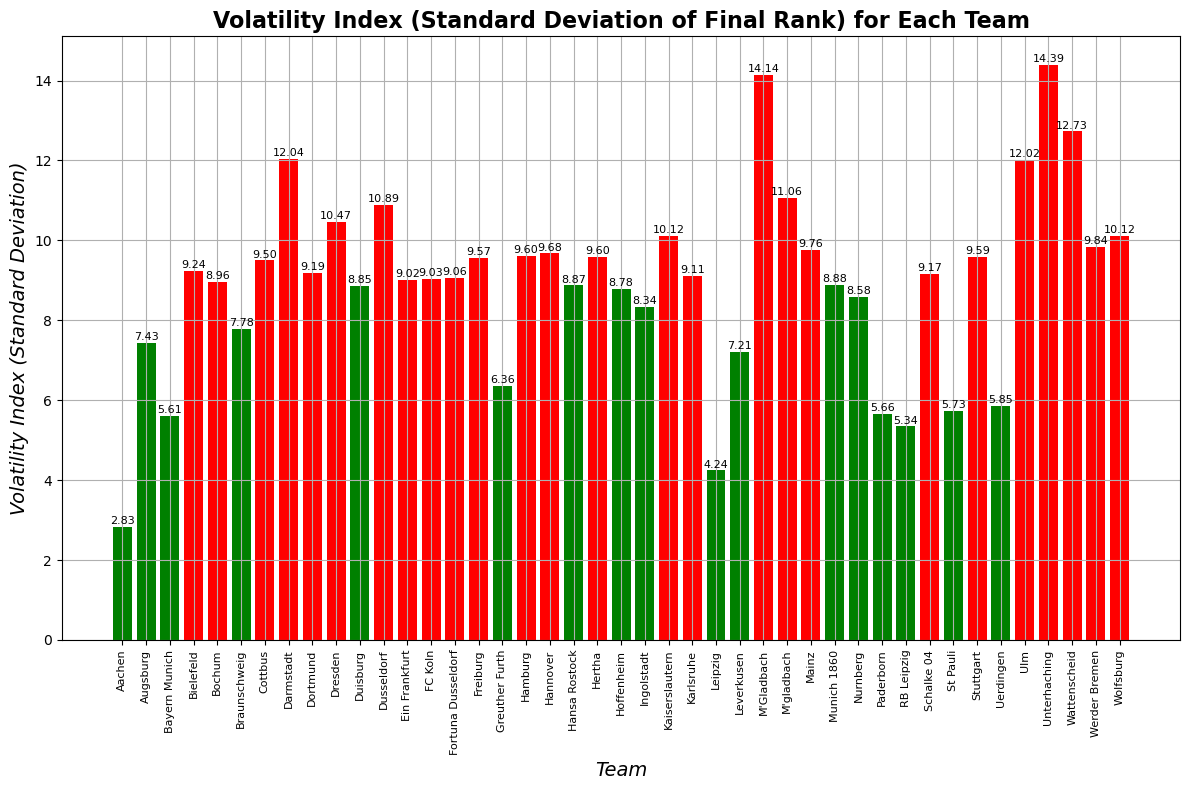

In [49]:
volatility_index = team_points.groupby('TEAM')['RANK'].std()

threshold = volatility_index.mean() 

volatility_index_color = ['red' if volatility_index[team] > threshold else 'green' for team in volatility_index.index]

plt.figure(figsize=(12, 8))

bars = plt.bar(volatility_index.index, volatility_index.values, color=volatility_index_color)

for bar, value in zip(bars, volatility_index.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=8)

plt.title('Volatility Index (Standard Deviation of Final Rank) for Each Team', fontsize=16, fontweight = "bold")
plt.xlabel('Team', fontsize=14, style = "italic")
plt.ylabel('Volatility Index (Standard Deviation)', fontsize=14, style = "italic")
plt.xticks(rotation=90, fontsize = 8)
plt.grid(True)

plt.tight_layout()
plt.show()

## Part 5: Overall performance

In [52]:
bundesliga['HOME_GD'] = bundesliga['FTHG'] - bundesliga['FTAG']  
bundesliga['AWAY_GD'] = bundesliga['FTAG'] - bundesliga['FTHG']  

season_gd = pd.DataFrame()

for match in range(len(bundesliga)):
    home_row = {
        'SEASON': bundesliga['SEASON'][match],
        'Team': bundesliga['HOMETEAM'][match],
        'GoalDifference': bundesliga['HOME_GD'][match]
    }
    
    away_row = {
        'SEASON': bundesliga['SEASON'][match],
        'Team': bundesliga['AWAYTEAM'][match],
        'GoalDifference': bundesliga['AWAY_GD'][match]
    }
    
    season_gd = pd.concat([season_gd, pd.DataFrame([home_row, away_row])], ignore_index=True)

season_gd = season_gd.groupby(['SEASON', 'Team'], as_index=False)['GoalDifference'].sum()

team_colors = {}
for season in season_gd['SEASON'].unique():
    teams_in_season = season_gd[season_gd['SEASON'] == season]['Team'].unique()
    color_palette = sns.color_palette("hls", n_colors=len(teams_in_season))
    for i, team in enumerate(teams_in_season):
        team_colors[team] = color_palette[i]

season_winners = season_gd.loc[season_gd.groupby('SEASON')['GoalDifference'].idxmax()]

with PdfPages('seasonal_team_goal_difference.pdf') as pdf:
    for season in season_gd['SEASON'].unique():
        season_data = season_gd[season_gd['SEASON'] == season]
        winner = season_winners[season_winners['SEASON'] == season]
        
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='GoalDifference', y='Team', data=season_data, hue='Team', palette=team_colors, orient='h')

        for i, bar in enumerate(ax.patches):
            if season_data.iloc[i]['Team'] == winner.iloc[0]['Team']:
                bar.set_edgecolor('black')
                bar.set_linewidth(2)
        
        plt.title(f"Season {season} Goal Difference", fontweight='bold')
        plt.xlabel("Goal Difference", fontweight='bold')
        plt.ylabel("Team", fontweight='bold')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        pdf.savefig()
        plt.close()

print("Graphs saved in 'seasonal_team_goal_difference.pdf'")

Graphs saved in 'seasonal_team_goal_difference.pdf'
